### Info

3D SDU-Net and 3D U-Net trained on Fidon dataset.

In [2]:
import sys
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchio as tio
import torchvision.transforms as transforms

from modules.Dataset import *
from modules import Evaluator3D, models
from modules.LossFunctions import DC_and_CE_loss, GDiceLossV2
from modules.Predictor import Predictor
from modules.Transforms import *
from modules.Utils import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_path = "../../Data/lucas/"

# Transformations.
transform_eval = None

# Split dataset.
lucas_val = MRIDataset(FeTABalancedDistribution, "val", dataset_path, transform=transform_eval)
lucas_test = MRIDataset(FeTABalancedDistribution, "test", dataset_path, transform=transform_eval)

torch.manual_seed(0)
lucas_val_loader = torch.utils.data.DataLoader(dataset=lucas_val, batch_size=1)
lucas_test_loader = torch.utils.data.DataLoader(dataset=lucas_test, batch_size=1)

lucas_val.meta_data = lucas_val.meta_data.drop(columns=['Unnamed: 3'])
lucas_test.meta_data = lucas_test.meta_data.drop(columns=['Unnamed: 3'])

In [5]:
criterion = DC_and_CE_loss({'batch_dice': True, 'smooth': 1e-5, 'do_bg': False, 'square': False}, {})

### Warning! 
Tensorboard event files contains validation scores, not test scores.

### 3D SDU-Net

In [6]:
path_events_file = '../../output/UNet3D/Iteration_20230107/SDUNet_4/events.out.tfevents.1673680512.DESKTOP-BN0TMAF.2172.0'
results = read_scalars(path_events_file, -1)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Epoch:  35


In [9]:
sdunet3d = models.SDUNet3D().to(device)
sdunet3d.load_state_dict(torch.load("../../output/UNet3D/Iteration_20230107/SDUNet_4/weights/34_model.pth"))

predictor = Predictor(sdunet3d, (128, 128, 128))
sub = lucas_test[5]

Validation : 100%|███████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.67s/it, Loss: -0.8199]


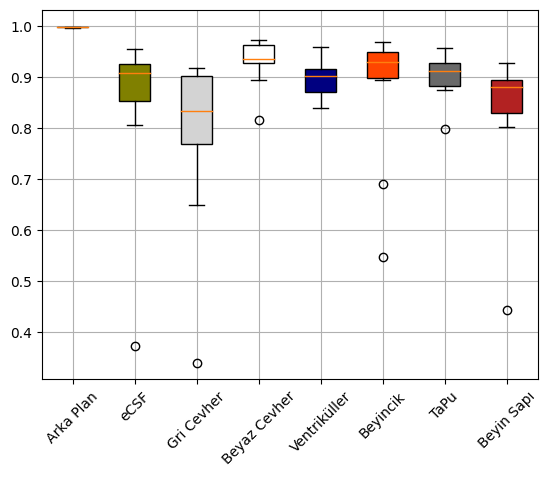

,0,1,2,3,4,5,6,7
0,0.998102,0.846972,0.784282,0.930061,0.899432,0.873131,0.900748,0.831035


In [10]:
evaluator = Evaluator3D(criterion, sdunet3d, (128, 128, 128), lucas_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, lucas_val, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.54s/it]


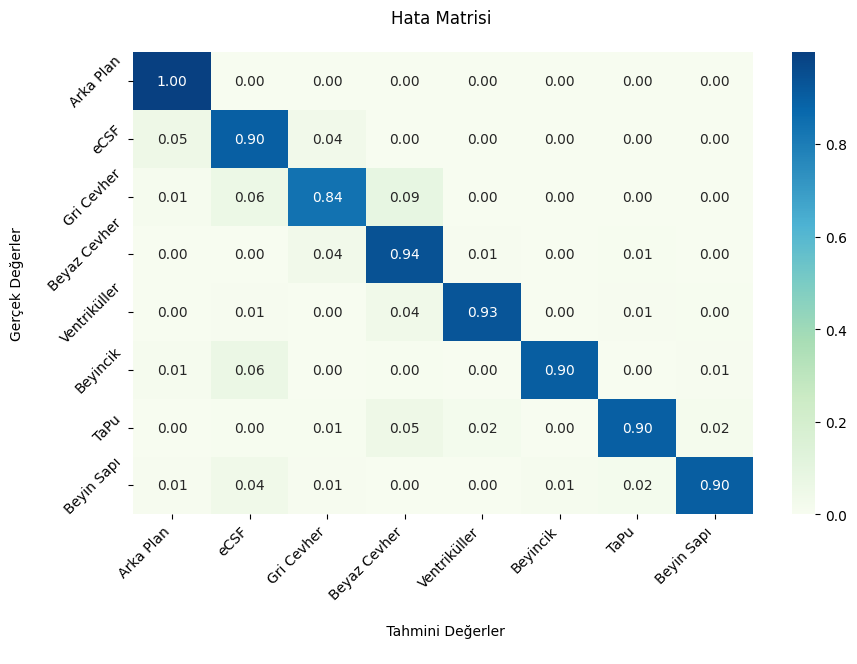

In [11]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix(lang='tr')

Validation : 100%|███████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.74s/it, Loss: -0.7967]


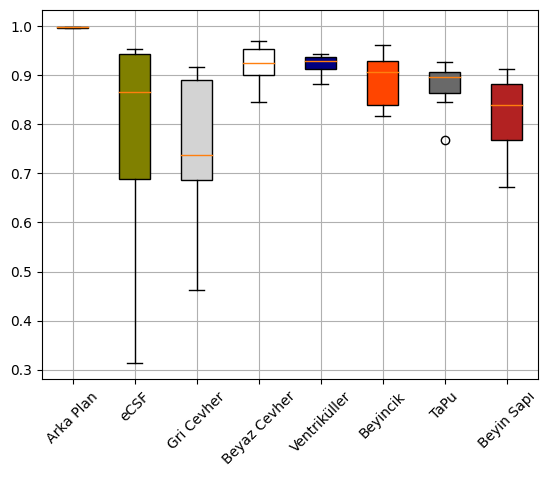

,0,1,2,3,4,5,6,7
0,0.997689,0.784458,0.748734,0.920517,0.921384,0.890412,0.881137,0.820385


In [12]:
tester = Evaluator3D(criterion, sdunet3d, (128, 128, 128), lucas_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, lucas_test, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.56s/it]


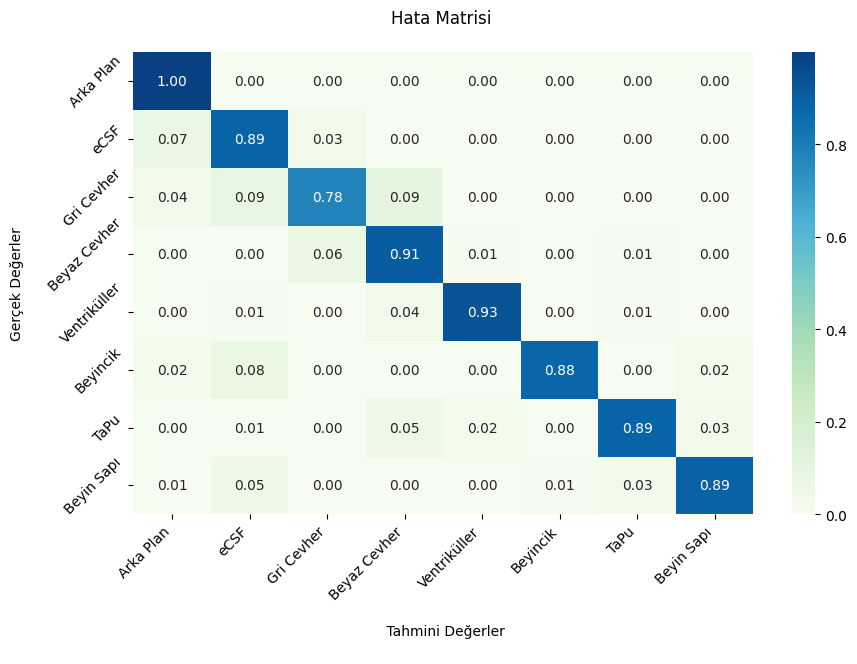

In [13]:
tester.calculate_cm()
tester.plot_confusion_matrix(lang='tr')

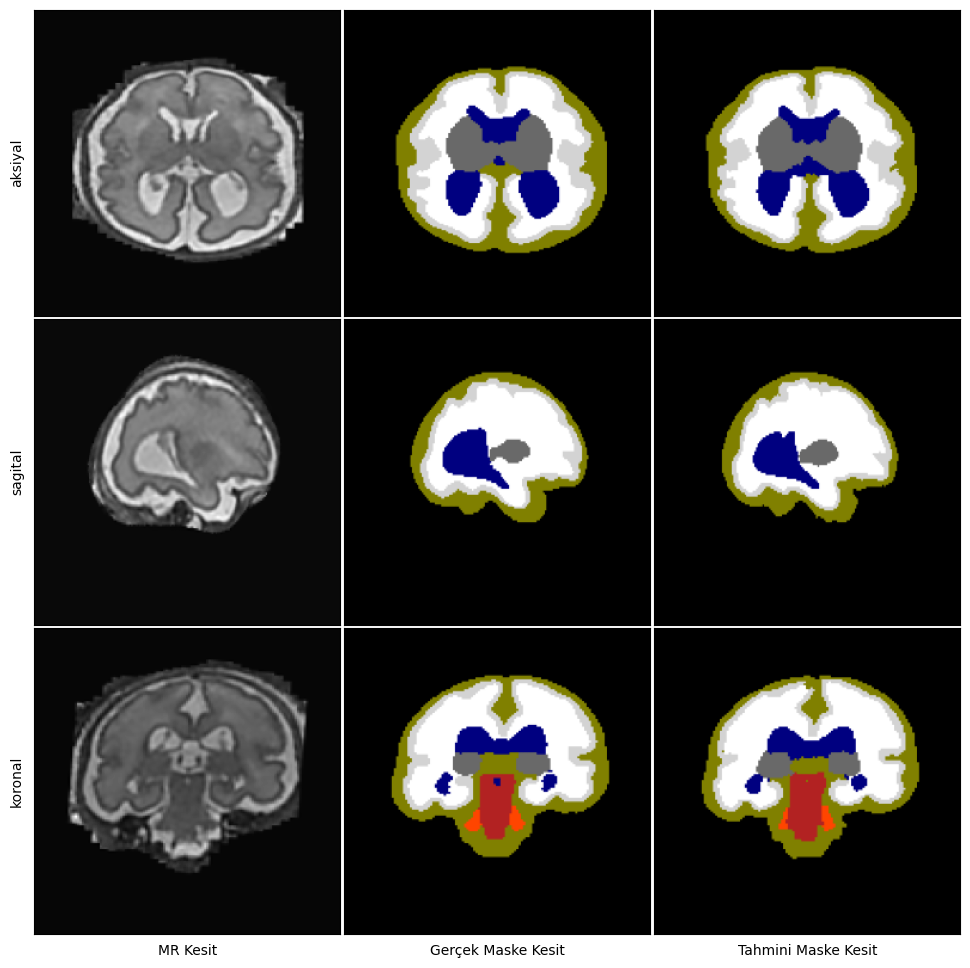

'sub-075'

In [14]:
prediction = predictor.predict(sub)
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 90

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)
sub.sub_id

### 3D U-Net

In [12]:
path_events_file = '../../output/UNet3D/Iteration_20230103/FeTABalanced_lucas/events.out.tfevents.1672826536.DESKTOP-BN0TMAF.9864.0'
results = read_scalars(path_events_file, -1)

Epoch:  20


In [19]:
unet3d = models.UNet3D().to(device)
unet3d.load_state_dict(torch.load("../../output/UNet3D/Iteration_20230103/FeTABalanced_lucas/weights/19_model.pth"))
predictor = Predictor(unet3d, (128, 128, 128))
sub = lucas_test[5]

Validation : 100%|███████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.99s/it, Loss: -0.8424]


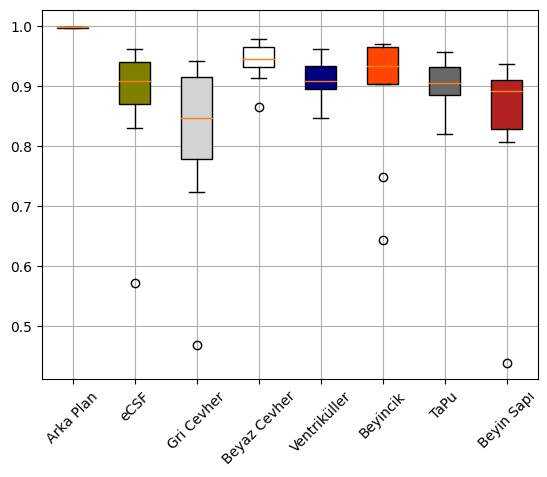

,0,1,2,3,4,5,6,7
0,0.998264,0.875479,0.816296,0.941387,0.912247,0.893473,0.904006,0.838066


In [21]:
evaluator = Evaluator3D(criterion, unet3d, (128, 128, 128), lucas_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, lucas_val, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.82s/it]


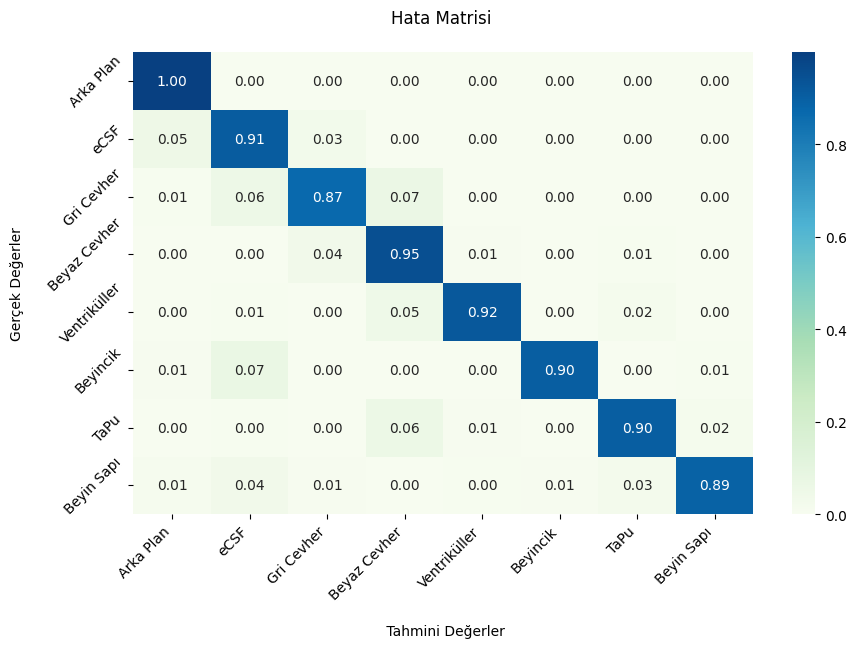

In [22]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix(lang='tr')

Validation : 100%|███████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.09s/it, Loss: -0.8196]


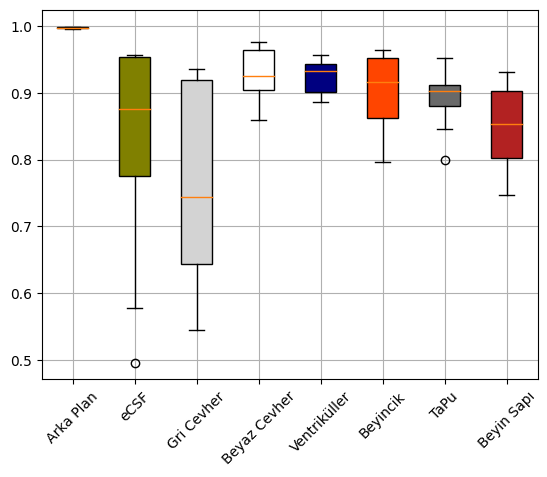

,0,1,2,3,4,5,6,7
0,0.997932,0.824551,0.764364,0.927237,0.923775,0.903206,0.894308,0.85018


In [23]:
tester = Evaluator3D(criterion, unet3d, (128, 128, 128), lucas_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, lucas_test, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.89s/it]


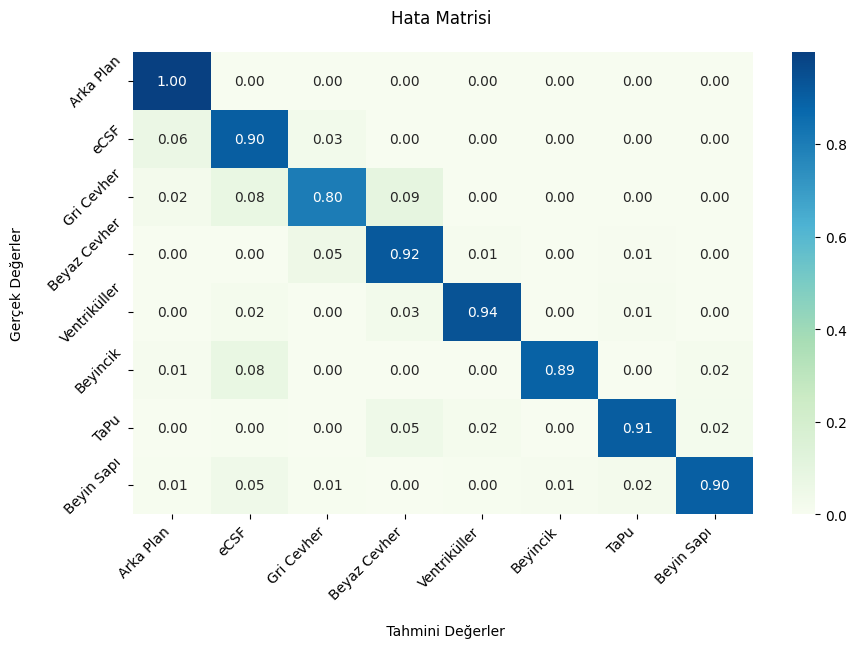

In [24]:
tester.calculate_cm()
tester.plot_confusion_matrix(lang='tr')

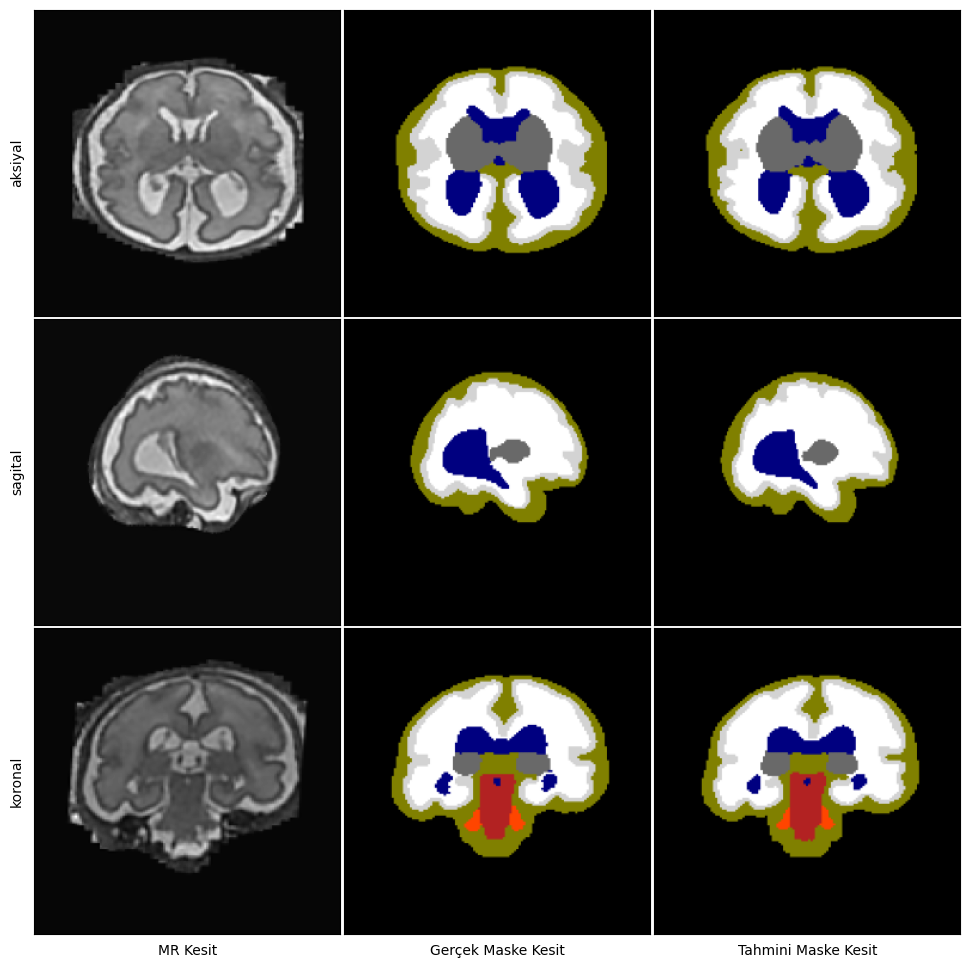

'sub-075'

In [26]:
prediction = predictor.predict(sub)
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 90

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)
sub.sub_id